# Car Price Prediction


Install packages


In [74]:
!uv pip install -q \
    python-dotenv==1.2.1 \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2

Append notebooks directory to sys.path


In [ ]:
import sys

sys.path.append("../../..")

Import packages


In [76]:
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple
import numpy as np
import seaborn as sns
import datetime
from dotenv import load_dotenv
from notebooks.python.utils.data_extraction.data_extraction import (
    KaggleDataExtractor,
    KaggleExtractionConfig,
)

pd.set_option("display.max_columns", None)

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

%matplotlib inline

load_dotenv()  # Root directory .env file

True

## Utility scripts:

**KaggleDataExtractor**:

```py
--8<-- "docs/notebooks/python/utils/data_extraction/data_extraction.py"
```


Create data directory


In [ ]:
DATA_DIR = pathlib.Path("data/predicting-car-price")

os.makedirs(DATA_DIR, exist_ok=True)

Download dataset from Kaggle


In [ ]:
username = os.getenv("KAGGLE_USERNAME")
api_token = os.getenv("KAGGLE_API_TOKEN")
file_name = "data.csv"

extractor = KaggleDataExtractor(username=username, api_token=api_token)

config = KaggleExtractionConfig(
    dataset_slug="CooperUnion/cardataset",
    file_name=file_name,
    destination_path=DATA_DIR,
    output_file_name="cars.csv",
)

if not os.path.isfile(DATA_DIR / "cars.csv"):
    extractor.download_dataset(config)

## Data Preparation


Load dataset


In [ ]:
df = pd.read_csv(DATA_DIR / "cars.csv")

df.head(n=2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


Clean column names


In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.head(n=2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


Inspect DataFrame types


In [ ]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

Select only object type columns


In [ ]:
object_type_columns = list(df.dtypes[df.dtypes == "object"].index)

Clean column values


In [ ]:
object_type_columns = list(df.dtypes[df.dtypes == "object"].index)
for column in object_type_columns:
    df[column] = df[column].str.lower().str.replace(" ", "_")

## Exploratory Data Analysis


Column summary


In [ ]:
df_summary = pd.DataFrame(
    {
        "column": df.columns,
        "dtype": [df[col].dtype for col in df.columns],
        "sample_unique": [df[col].unique()[:6] for col in df.columns],
        "n_unique": [df[col].nunique() for col in df.columns],
    }
)
df_summary

,column,dtype,sample_unique,n_unique
0,make,object,"[bmw, audi, fiat, mercedes-benz, chrysler, nis...",48
1,model,object,"[1_series_m, 1_series, 100, 124_spider, 190-cl...",914
2,year,int64,"[2011, 2012, 2013, 1992, 1993, 1994]",28
3,engine_fuel_type,object,"[premium_unleaded_(required), regular_unleaded...",10
4,engine_hp,float64,"[335.0, 300.0, 230.0, 320.0, 172.0, 160.0]",356
5,engine_cylinders,float64,"[6.0, 4.0, 5.0, 8.0, 12.0, 0.0]",9
6,transmission_type,object,"[manual, automatic, automated_manual, direct_d...",5
7,driven_wheels,object,"[rear_wheel_drive, front_wheel_drive, all_whee...",4
8,number_of_doors,float64,"[2.0, 4.0, 3.0, nan]",3
9,market_category,object,"[factory_tuner,luxury,high-performance, luxury...",71


Price distribution


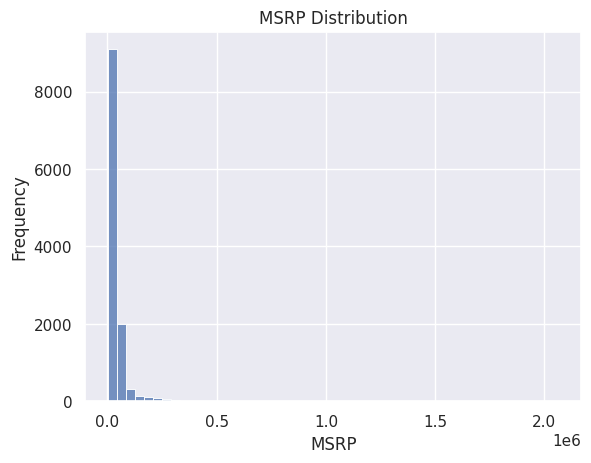

In [ ]:
sns.histplot(data=df.msrp, bins=50)
plt.title("MSRP Distribution")
plt.xlabel("MSRP")
plt.ylabel("Frequency")
plt.show()

A long tail distribution is observed, with a few cars priced very high.


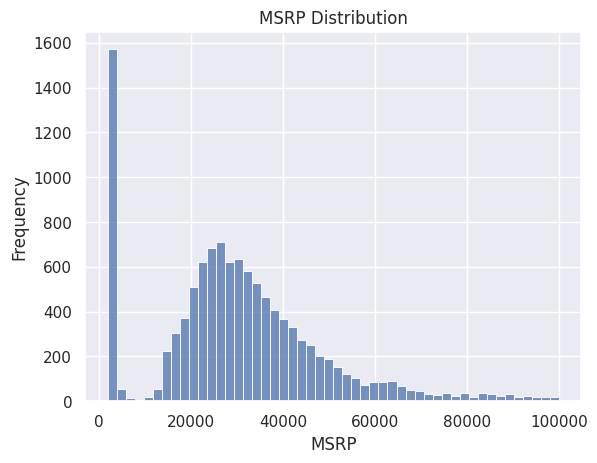

In [ ]:
# 1e6 = 1,000,000
sns.histplot(data=df.msrp[df.msrp < 100000], bins=50)
plt.title("MSRP Distribution")
plt.xlabel("MSRP")
plt.ylabel("Frequency")
plt.show()

Convert to log scale to reduce skewness, when doing an Machine Learning model, a skewed target variable can lead to suboptimal model performance.


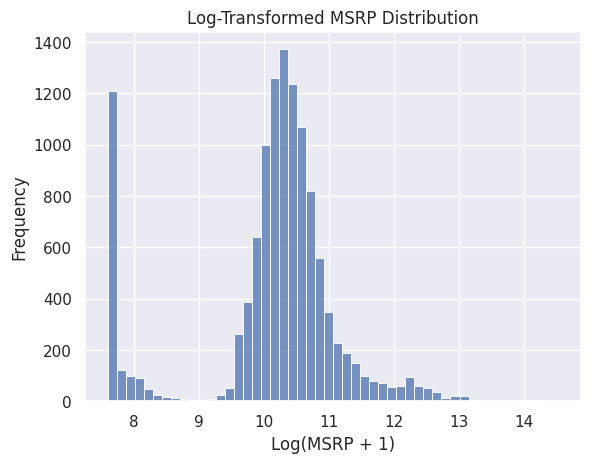

In [ ]:
price_log = np.log1p(df.msrp)  # sum of 1 to avoid log(0)
sns.histplot(data=price_log, bins=50)
plt.title("Log-Transformed MSRP Distribution")
plt.xlabel("Log(MSRP + 1)")
plt.ylabel("Frequency")
plt.show()

Missing values


In [ ]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## Validation Framework


Set split sizes

- Training dataset: 60%
- Validation dataset: 20%
- Test dataset: 20%


In [ ]:
dataframe_size = len(df)
validation_size = int(dataframe_size * 0.2)
test_size = int(dataframe_size * 0.2)
train_size = int(dataframe_size - validation_size - test_size)

validation_size, test_size, train_size

(2382, 2382, 7150)

Split DataFrame into train, validation and test sizes


In [ ]:
df_index = np.arange(dataframe_size)

np.random.seed(2)  # make reproducible
np.random.shuffle(df_index)

df_train = df.iloc[df_index[:train_size]]
df_validation = df.iloc[df_index[train_size : train_size + validation_size]]
df_test = df.iloc[df_index[train_size + validation_size :]]

df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


len(df_train), len(df_validation), len(df_test)

(7150, 2382, 2382)

In [ ]:
df_train.head(n=2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,14410
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,19685


Define prediction target


In [ ]:
y_train = np.log1p(df_train.msrp.values)
y_validation = np.log1p(df_validation.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [ ]:
df_train.drop(columns=["msrp"], inplace=True, errors="ignore")
df_validation.drop(columns=["msrp"], inplace=True, errors="ignore")
df_test.drop(columns=["msrp"], inplace=True, errors="ignore")

"msrp" in df_train.columns, "msrp" in df_validation.columns, "msrp" in df_test.columns

(False, False, False)

## Linear Regression


Linear Regression formula:

$$g(x_i) = w_0 + \sum_{j=1}^{n} w_j x_{ij}$$


Choosing an observation


In [ ]:
df_train.iloc[10]

make                                 rolls-royce
model                     phantom_drophead_coupe
year                                        2015
engine_fuel_type     premium_unleaded_(required)
engine_hp                                  453.0
engine_cylinders                            12.0
transmission_type                      automatic
driven_wheels                   rear_wheel_drive
number_of_doors                              2.0
market_category        exotic,luxury,performance
vehicle_size                               large
vehicle_style                        convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 10, dtype: object

Selecting features


In [ ]:
xi = df_train[["engine_hp", "city_mpg", "popularity"]].iloc[10].to_list()

xi

[453.0, 11.0, 86.0]

Defining weights


- **bias term (w0)**: Is the baseline of how much should cost the car if you do not know nothing about it.


In [ ]:
weight_zero = 7.17  # should be learned from data
weights_for_each_feature = [0.01, 0.04, 0.002]  # should be learned from data

w_new = [weight_zero] + weights_for_each_feature
w_new

[7.17, 0.01, 0.04, 0.002]

Defining linear regression formula


In [ ]:
def dot_product(xi, w):
    number_of_features = len(xi)

    result = 0.0
    for feature_index in range(number_of_features):
        result = result + xi[feature_index] * w[feature_index]

    return result


def linear_regression(xi):
    bias_term = 1  # will multiply the weight zero
    xi = [bias_term] + xi

    return dot_product(xi, w_new)

In [ ]:
prediction_result = linear_regression(xi)
np.expm1(prediction_result)  # undo the log -1 with np.expm1

np.float64(222347.2221101062)

### Linear Regression Vector form


Defining weights


In [ ]:
weight_zero = 7.17  # should be learned from data
weights_for_each_feature = [0.01, 0.04, 0.002]  # should be learned from data

w_new = [weight_zero] + weights_for_each_feature
w_new

[7.17, 0.01, 0.04, 0.002]

Select observations


In [ ]:
X = (
    df_train[["engine_hp", "city_mpg", "popularity"]]
    .iloc[[1, 2, 10]]
    .to_numpy()
)

X_with_bias = np.array([[1, *row] for row in X])
X_with_bias

array([[1.000e+00, 1.320e+02, 2.500e+01, 2.031e+03],
       [1.000e+00, 1.480e+02, 2.800e+01, 6.400e+02],
       [1.000e+00, 4.530e+02, 1.100e+01, 8.600e+01]])

Define linear regression formula to be applied in a vector


In [ ]:
def linear_regression_of_vector(X):
    return X.dot(w_new)

In [ ]:
np.expm1(linear_regression_of_vector(X_with_bias))

array([768348.51018973,  62942.95460551, 222347.22211011])

## Training a Linear Regression model


Get observations


In [ ]:
X_20 = df_train[["engine_hp", "city_mpg", "popularity"]].iloc[:20].to_numpy()
X_20

array([[ 148.,   24., 1385.],
       [ 132.,   25., 2031.],
       [ 148.,   28.,  640.],
       [  90.,   16.,  873.],
       [ 385.,   15., 5657.],
       [ 170.,   22.,  873.],
       [ 500.,   14.,  520.],
       [ 315.,   21., 3916.],
       [ 543.,   10.,   67.],
       [ 202.,   13., 5657.],
       [ 453.,   11.,   86.],
       [ 182.,   20., 1385.],
       [ 162.,   20.,  436.],
       [ 553.,   16., 2774.],
       [ 272.,   18., 3105.],
       [ 160.,   29.,  640.],
       [ 348.,   17., 1439.],
       [ 151.,   18.,  436.],
       [ 210.,   15., 1851.],
       [ 164.,   18., 5657.]])

In [ ]:
ones_20 = np.ones(X_20.shape[0])
ones_20

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [ ]:
X_20 = np.column_stack([ones_20, X_20])

In [ ]:
y_train_20 = y_train[:20]
y_train_20

array([ 9.57574708,  9.887663  ,  9.89323518,  7.60140233, 10.93775686,
        9.77428961, 12.16212598, 11.23981668, 12.84542604, 10.16704341,
       13.08107461, 10.42439221, 10.23995979, 12.20092944, 10.88183247,
       10.28520627, 10.42676533,  7.60140233, 10.13642301,  7.60140233])

$X^{t} \cdot X$


In [ ]:
XTX = X_20.T.dot(X_20)
XTX

array([[2.00000000e+01, 5.28800000e+03, 3.70000000e+02, 3.94280000e+04],
       [5.28800000e+03, 1.81620600e+06, 8.86050000e+04, 1.03710600e+07],
       [3.70000000e+02, 8.86050000e+04, 7.36000000e+03, 7.01793000e+05],
       [3.94280000e+04, 1.03710600e+07, 7.01793000e+05, 1.45140372e+08]])

Create an inverse matrix


In [ ]:
XTX_inv = np.linalg.inv(XTX)

Check if inverse matrix $(X^{t} \cdot X)^{-1}$ is an identity matrix


In [ ]:
XTX.dot(XTX_inv).round(1)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -0.],
       [ 0., -0.,  1., -0.],
       [ 0., -0.,  0.,  1.]])

Calculate the weights (coefficients) of the regression model.


In [ ]:
w_20 = XTX_inv.dot(X_20.T).dot(y_train_20)
w_20

array([ 6.60542123e+00,  1.01942686e-02,  6.59118053e-02, -8.72271244e-05])

Separate the weights for each feature and the _bias term_


In [ ]:
w0_20 = w_20[0]
w_20 = w_20[1:]

w0_20, w_20

(np.float64(6.605421234877432),
 array([ 1.01942686e-02,  6.59118053e-02, -8.72271244e-05]))

Define train function


In [ ]:
def train_linear_regression(
    X: np.ndarray, y: np.ndarray
) -> Tuple[float, np.ndarray]:
    """
    Returns:
        w0 (float): bias term
        w (np.ndarray): weight vector
    """
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

Train to get the weights


In [ ]:
train_linear_regression(
    df_train[["engine_hp", "city_mpg", "popularity"]].iloc[:20].to_numpy(),
    y_train[:20],
)

(np.float64(6.605421234877432),
 array([ 1.01942686e-02,  6.59118053e-02, -8.72271244e-05]))

## Baseline Model


In [ ]:
base_features = [
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",
    "popularity",
]

X_train = df_train[base_features].fillna(0).values
w0_train, w_train = train_linear_regression(X_train, y_train)
y_pred_train = w0_train + X_train.dot(w_train)

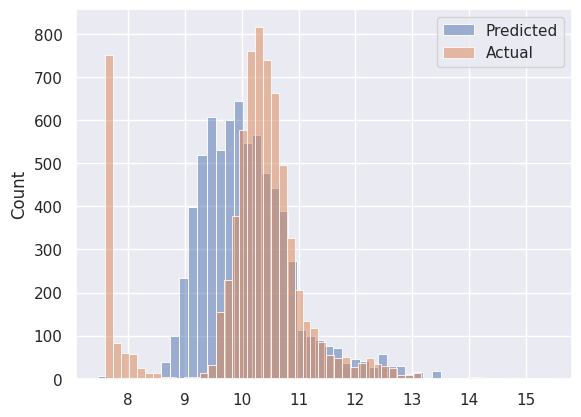

In [ ]:
sns.histplot(y_pred_train, bins=50, alpha=0.5, label="Predicted")
sns.histplot(y_train, bins=50, alpha=0.5, label="Actual")
plt.legend()
plt.show()

## RMSE

Root Mean Square Error

- Get the diferences between each real actual and predicted value
- Square the difference
- Take average of the differences

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$


Define RMSE function


In [ ]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error**2
    mse = se.mean()

    return np.sqrt(mse)

Calculate the RMSE for actual and predicted values


In [ ]:
rmse(y_train, y_pred_train)

np.float64(0.7554192603920132)

## Validating the model


In [ ]:
base_features = [
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",
    "popularity",
]

X_validation = df_validation[base_features].fillna(0).values
w0_validation, w_validation = train_linear_regression(
    X_validation, y_validation
)
y_pred_validation = w0_validation + X_validation.dot(w_validation)

rmse(y_validation, y_pred_validation)

np.float64(0.751003347391545)

## Feature Engineering


Get current year to calculate car age


In [ ]:
datetime.datetime.now().year

2025

Prepare the features


In [ ]:
def prepare_X(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["age"] = datetime.datetime.now().year - df.year

    features = [
        "engine_hp",
        "engine_cylinders",
        "highway_mpg",
        "city_mpg",
        "popularity",
    ] + ["age"]

    _df = df[features]
    _df = _df.fillna(0)
    X = _df.values
    return X

Apply some feature engineering


In [ ]:
X_train_processed = prepare_X(df_train)
X_train_processed

array([[ 148.,    4.,   33.,   24., 1385.,   17.],
       [ 132.,    4.,   32.,   25., 2031.,   13.],
       [ 148.,    4.,   37.,   28.,  640.,    9.],
       ...,
       [ 285.,    6.,   22.,   17.,  549.,   10.],
       [ 563.,   12.,   21.,   13.,   86.,   11.],
       [ 200.,    4.,   31.,   22.,  873.,    8.]], shape=(7150, 6))

Check if model has improved


In [ ]:
w0_train_processed, w_train_processed = train_linear_regression(
    X_train_processed, y_train
)
y_pred_train_processed = w0_train_processed + X_train_processed.dot(
    w_train_processed
)

rmse(y_train, y_pred_train_processed)

np.float64(0.5175055465840046)

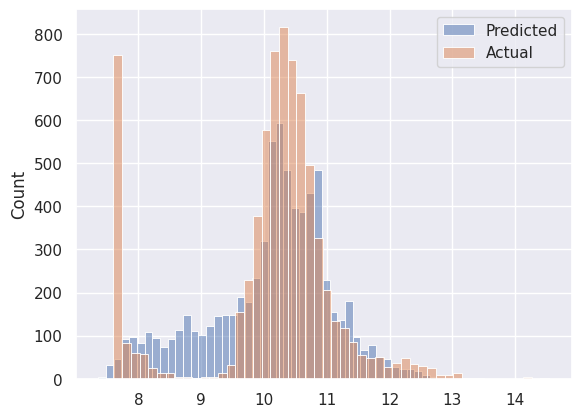

In [ ]:
sns.histplot(y_pred_train_processed, bins=50, alpha=0.5, label="Predicted")
sns.histplot(y_train, bins=50, alpha=0.5, label="Actual")
plt.legend()
plt.show()

### Categorical features


In [ ]:
df_train["number_of_doors"].fillna(0).unique().astype(int)

array([2, 4, 3, 0])

Add number of doors


In [ ]:
def prepare_X(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["age"] = datetime.datetime.now().year - df.year

    # Doors
    doors = df["number_of_doors"].fillna(0).astype(int)
    doors = doors[doors > 0]
    for n in doors.unique():
        df[f"door_{n}"] = (doors == n).astype(int)

    features = (
        [
            "engine_hp",
            "engine_cylinders",
            "highway_mpg",
            "city_mpg",
            "popularity",
        ]
        + ["age"]
        + [f"door_{n}" for n in doors.unique()]
    )

    X = df[features].fillna(0).values
    return X

Check if RMSE had any improvement


In [ ]:
X_train_processed = prepare_X(df_train)

w0_train_processed, w_train_processed = train_linear_regression(
    X_train_processed, y_train
)
y_pred_train_processed = w0_train_processed + X_train_processed.dot(
    w_train_processed
)

rmse(y_train, y_pred_train_processed)

np.float64(0.5150615580371418)

Inspect make attribute


In [ ]:
df.make.nunique()

48

In [ ]:
df.make.value_counts().head().index.tolist()

['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']

Add Make to preparation


In [ ]:
def prepare_X(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["age"] = datetime.datetime.now().year - df.year

    # Doors
    doors = df["number_of_doors"].fillna(0).astype(int)
    doors = doors[doors > 0]
    for n in doors.unique():
        df[f"door_{n}"] = (doors == n).astype(int)

    # Car makes (top 5)
    top_makes = df["make"].value_counts().head().index
    for m in top_makes:
        df[f"is_{m}"] = (df["make"] == m).astype(int)

    features = (
        [
            "engine_hp",
            "engine_cylinders",
            "highway_mpg",
            "city_mpg",
            "popularity",
        ]
        + ["age"]
        + [f"door_{n}" for n in doors.unique()]
        + [f"is_{m}" for m in top_makes]
    )

    X = df[features].fillna(0).values
    return X

Check if RMSE had any improvement


In [ ]:
X_train_processed = prepare_X(df_train)

w0_train_processed, w_train_processed = train_linear_regression(
    X_train_processed, y_train
)
y_pred_train_processed = w0_train_processed + X_train_processed.dot(
    w_train_processed
)

rmse(y_train, y_pred_train_processed)

np.float64(0.5058876515487503)

Add another categorical features


In [ ]:
def get_feature_names(df: pd.DataFrame, top_n: int = 5):
    CATEGORICAL_COLS = [
        "make",
        "engine_fuel_type",
        "transmission_type",
        "driven_wheels",
        "market_category",
        "vehicle_size",
        "vehicle_style",
    ]

    numeric_features = [
        "engine_hp",
        "engine_cylinders",
        "highway_mpg",
        "city_mpg",
        "popularity",
        "age",
    ]

    doors_ref = df["number_of_doors"].fillna(0).astype(int)
    valid_doors = sorted(doors_ref[doors_ref > 0].unique())
    door_features = [f"door_{n}" for n in valid_doors]

    all_cat_features = []
    for col in CATEGORICAL_COLS:
        if col in df.columns:
            top_values = df[col].value_counts().head(top_n).index
            for val in top_values:
                all_cat_features.append(f"{col}__{val}")

    features = numeric_features + door_features + all_cat_features
    return features


def prepare_X(
    df: pd.DataFrame, feature_names: list | None = None, top_n: int = 5
) -> np.ndarray:
    df = df.copy()
    df["age"] = datetime.datetime.now().year - df["year"]

    if feature_names is None:
        feature_names = get_feature_names(df, top_n=top_n)

    # Build door indicator columns (if defined in feature_names)
    doors = df["number_of_doors"].fillna(0).astype(int)
    for fname in feature_names:
        if fname.startswith("door_"):
            try:
                n = int(fname.split("_", 1)[1])
            except Exception:
                continue
            df[fname] = (doors == n).astype(int)

    # Build categorical indicator columns (col__value)
    for fname in feature_names:
        if "__" in fname:
            col, val = fname.split("__", 1)
            if col in df.columns:
                df[fname] = (df[col] == val).astype(int)
            else:
                df[fname] = 0

    for fname in feature_names:
        if fname not in df.columns:
            df[fname] = 0

    X = df[feature_names].fillna(0).values
    return X

Check if RMSE had any improvement


In [ ]:
X_train_processed = prepare_X(df_train)

w0_train_processed, w_train_processed = train_linear_regression(
    X_train_processed, y_train
)
y_pred_train_processed = w0_train_processed + X_train_processed.dot(
    w_train_processed
)

rmse(y_train, y_pred_train_processed)

np.float64(56.92865879395615)

## Regularization


Add a penalty to the model so the coefficients don't grow too large


Extend linear regression function with regularization


In [ ]:
def train_linear_regression_regularized(
    X: np.ndarray, y: np.ndarray, r=0.001
) -> Tuple[float, np.ndarray]:
    """
    Returns:
        w0 (float): bias term
        w (np.ndarray): weight vector
    """
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

Check if RMSE had any improvement


In [ ]:
X_train_processed = prepare_X(df_train)

w0_train_processed, w_train_processed = train_linear_regression_regularized(
    X_train_processed, y_train, r=0.01
)
y_pred_train_processed = w0_train_processed + X_train_processed.dot(
    w_train_processed
)

rmse(y_train, y_pred_train_processed)

np.float64(0.46020997851360806)

## Tunning the model


In [ ]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train_processed = prepare_X(df_train)

    w0_train_processed, w_train_processed = (
        train_linear_regression_regularized(X_train_processed, y_train, r=r)
    )
    y_pred_train_processed = w0_train_processed + X_train_processed.dot(
        w_train_processed
    )

    print(r, w0_train_processed, rmse(y_train, y_pred_train_processed))

0.0 -1.8213982233756756e+16 56.92865879395615
1e-05 7.508616279702774 0.4602097255816646
0.0001 6.735043149776942 0.460209725607043
0.001 6.7172860116527335 0.46020972813885674
0.1 6.616538114296875 0.4602325804440284
1 6.020498824907903 0.46131094140340545
10 4.53801320150478 0.4769658017455763


## Using the model


Concatenate train and validation datasets


In [ ]:
df_complete_train = pd.concat([df_train, df_validation])
df_complete_train.reset_index(drop=True, inplace=True)
df_complete_train.head(n=2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031


Concatenate train and validation targets


In [ ]:
y_complete_train = np.concatenate([y_train, y_validation])

Train model with complete dataset (train + validation) then predict y_test


In [ ]:
X_complete_train_processed = prepare_X(df_complete_train)

w0_complete_train_processed, w_complete_train_processed = (
    train_linear_regression_regularized(
        X_complete_train_processed, y_complete_train, r=0.01
    )
)

X_test_processed = prepare_X(df_test)
y_test_prediction = w0_complete_train_processed + X_test_processed.dot(
    w_complete_train_processed
)

rmse(y_test, y_test_prediction)

np.float64(0.4517743247231621)

Inspect object


In [ ]:
car = df_test.iloc[20].to_dict()
car

{'make': 'toyota',
 'model': 'sienna',
 'year': 2015,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 266.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'large',
 'vehicle_style': 'passenger_minivan',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

Predict its value


In [ ]:
feature_names = get_feature_names(df_complete_train, top_n=5)

X_complete_train_processed = prepare_X(
    df_complete_train, feature_names=feature_names
)
w0_complete_train_processed, w_complete_train_processed = (
    train_linear_regression_regularized(
        X_complete_train_processed, y_complete_train, r=0.01
    )
)

df_car_observation = pd.DataFrame([car])
X_car_observation = prepare_X(df_car_observation, feature_names=feature_names)
y_car_observation_prediction = (
    w0_complete_train_processed
    + X_car_observation.dot(w_complete_train_processed)
)

np.expm1(y_car_observation_prediction)

array([34980.16910953])

Compare with actual value


In [ ]:
np.expm1(y_test[20])

np.float64(35000.00000000001)